In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 55555555
np.random.seed(RANDOM_STATE)

param_grid = {
    "learning_rate": [i/1000 for i in range(1, 502, 5)],
    "max_depth": [2, 3, 4, 5],
    "n_estimators": [300]}


In [3]:
df = pd.read_excel("Rounds2-6_data.xlsx", sheet_name=0)
X = df.iloc[:, 4:].to_numpy()
y = df["IgG_product"].to_numpy()

In [6]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE + 1)

In [7]:
records = []

fold_id = 0
for tr_idx, te_idx in outer_cv.split(X, y):
    fold_id += 1
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    base = GradientBoostingRegressor(random_state=RANDOM_STATE)
    gs = GridSearchCV(
        estimator=base,
        param_grid=param_grid,
        scoring="r2",
        cv=inner_cv,
        n_jobs=-1,
        refit=True)
    
    gs.fit(X_tr, y_tr)

    y_pred = gs.best_estimator_.predict(X_te)

    for idx, yt, yp in zip(te_idx, y_te, y_pred):
        records.append({"outer_fold": fold_id, "row_index": int(idx), "y_true": float(yt), "y_pred": float(yp)})

In [8]:
pred_df = pd.DataFrame(records).sort_values(["outer_fold", "row_index"]).reset_index(drop=True)
pred_df

,outer_fold,row_index,y_true,y_pred
0,1,0,0.860108,0.772553
1,1,1,0.770758,0.824822
2,1,7,0.689531,0.709049
3,1,21,0.846570,0.849868
4,1,24,0.693396,0.791510
...,...,...,...,...
134,5,109,1.410504,1.478229
135,5,111,1.038198,1.329321
136,5,124,1.580159,1.676482
137,5,127,1.440213,1.647954


In [9]:
results = []

for fold_id, group in pred_df.groupby("outer_fold"):
    y_true = group["y_true"].values
    y_pred = group["y_pred"].values

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    results.append({
        "outer_fold": fold_id,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae})

In [10]:
results_df = pd.DataFrame(results)
mean_row = results_df.mean(numeric_only=True)
std_row = results_df.std(numeric_only=True, ddof=1)

summary = pd.DataFrame({
    "outer_fold": ["mean", "std"],
    "R2": [mean_row["R2"], std_row["R2"]],
    "RMSE": [mean_row["RMSE"], std_row["RMSE"]],
    "MAE": [mean_row["MAE"], std_row["MAE"]],})

final_df = pd.concat([results_df, summary], ignore_index=True)

final_df


,outer_fold,R2,RMSE,MAE
0,1,0.725598,0.157528,0.130329
1,2,0.526048,0.222933,0.168312
2,3,0.785509,0.163309,0.118195
3,4,0.584903,0.219721,0.149496
4,5,0.661764,0.186738,0.149494
5,mean,0.656764,0.190046,0.143165
6,std,0.104390,0.030600,0.019370


In [11]:
final_df.to_csv("nestedCV.csv")

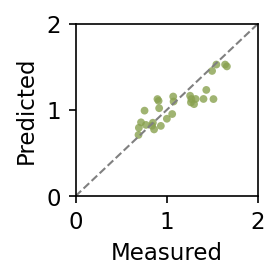

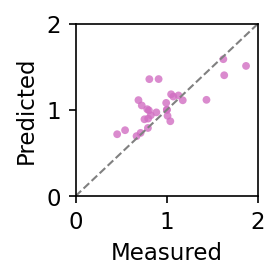

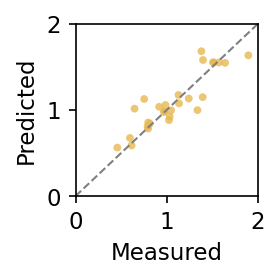

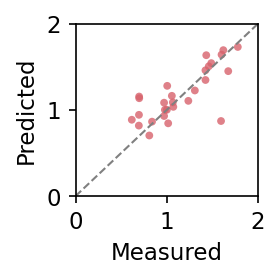

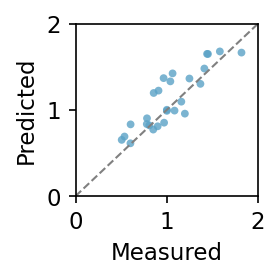

In [14]:
folds = sorted(pred_df["outer_fold"].unique())

c_label = ["#89a14f", "#d16ec2", "#e7b851", "#d7626c", "#5aa2c6", "#7f7f7f"]

for i, fold_id in enumerate(folds):
    df_fold = pred_df[pred_df["outer_fold"] == fold_id]
    y_true = df_fold["y_true"].to_numpy()
    y_pred = df_fold["y_pred"].to_numpy()

    plt.figure(figsize=(2, 2), dpi=150)
    plt.rcParams["font.size"] = 11
    plt.scatter(y_true, y_pred, s=14, color=c_label[i % len(c_label)], edgecolor="none", alpha=0.8)

    plt.plot([0, 2], [0, 2], linestyle="--", color="gray", linewidth=1)
    
    plt.xlabel("Measured")
    plt.ylabel("Predicted")

    plt.xlim(0,2)
    plt.ylim(0,2)
    plt.xticks([0, 1, 2])
    plt.yticks([0, 1, 2]) 
    plt.tight_layout()

    plt.savefig(f"fold_{fold_id}.png", dpi=300, bbox_inches='tight')